# StarDist Training Notebook. Use this for making your own models
Feb 2024

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import os
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize, download_and_extract_zip_file


from stardist import fill_label_holes, relabel_image_stardist, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

/tmp/slurm_64206910/ipykernel_253758/108201305.py:6: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams["image.interpolation"] = None
2024-01-30 17:02:38.517303: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
#Check to see if GPU is enabled
gputools_available()

If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3


True

# Data


### When formatting your data for training, pay careful attention to how the data is formatted in the sample case. You will want to name your images in the same manner.

### Note! Labels that are made by humans are typically called the "ground truth"

<div class="alert alert-block alert-info">
Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size.  
Input images can either be two-dimensional (single-channel) or three-dimensional (multi-channel) arrays, where the channel axis comes last. Label images need to be integer-valued.
</div>

## Set up your data!

* X is the training images
* Y is the training labels (masks)

In [3]:
# set the path to train and test data
train_image_path = "/camp/home/fallest/working/fallest/StarDist_Course_Feb_2024/Course_Data/DAPI_Data/Training/train/images/"
train_mask_path ="/camp/home/fallest/working/fallest/StarDist_Course_Feb_2024/Course_Data/DAPI_Data/Training/train/masks/"

In [4]:
X = sorted(glob(train_image_path+'*.tif'))
Y = sorted(glob(train_mask_path+'/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

### Check your files, make sure it is listed properly.  If you have less than three images, change the [0:3]

In [5]:
print('The first three label images are: ',*X[0:3], sep='\n')
print('')
print('The first three label images are: ',*Y[0:3], sep='\n')

The first three label images are: 
/camp/home/fallest/working/fallest/StarDist_Course_Feb_2024/Course_Data/DAPI_Data/Training/train/images/Crop_1.tif
/camp/home/fallest/working/fallest/StarDist_Course_Feb_2024/Course_Data/DAPI_Data/Training/train/images/Crop_2.tif
/camp/home/fallest/working/fallest/StarDist_Course_Feb_2024/Course_Data/DAPI_Data/Training/train/images/Crop_3.tif

The first three label images are: 
/camp/home/fallest/working/fallest/StarDist_Course_Feb_2024/Course_Data/DAPI_Data/Training/train/masks/Crop_1.tif
/camp/home/fallest/working/fallest/StarDist_Course_Feb_2024/Course_Data/DAPI_Data/Training/train/masks/Crop_2.tif
/camp/home/fallest/working/fallest/StarDist_Course_Feb_2024/Course_Data/DAPI_Data/Training/train/masks/Crop_3.tif


In [6]:
X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

## Normalize images and fill small label holes.

In [7]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 170.23it/s]


### Do the automatic train test split

In [8]:

assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:   4
- training:         3
- validation:       1


### Training data consists of pairs of input image and label instances. Plot them together as a sanity check

In [9]:

def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

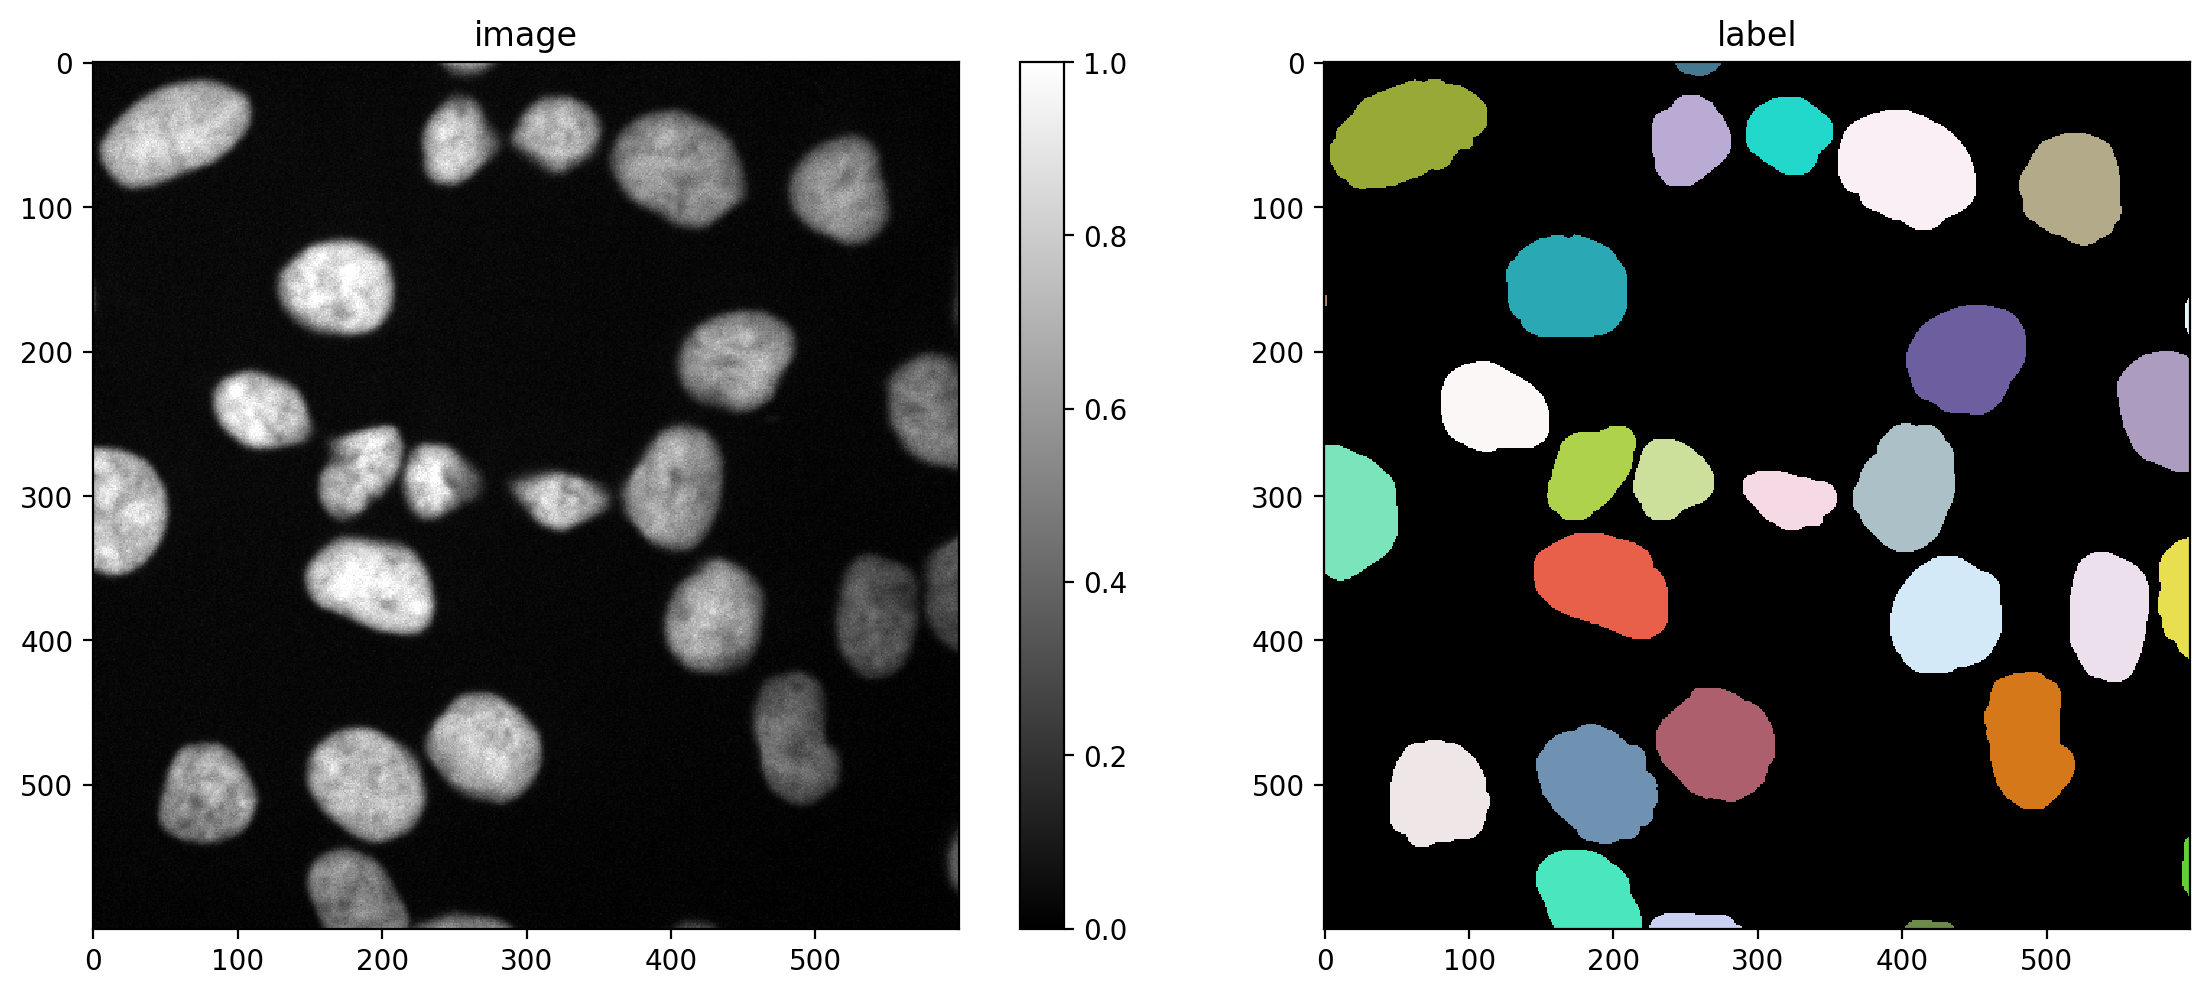

In [10]:
i = min(9, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)
None;

# Configuration

A `StarDist2D` model is specified via a `Config2D` object.

In [11]:
#print(Config2D.__doc__)

# Example image


# See an image with it's ground truth labels

In [12]:
##Make up list of images and their labels

i = min(4, len(X)-1)
img, lbl = X[i], fill_label_holes(Y[i])
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3]
# assumed axes ordering of img and lbl is: YX(C)

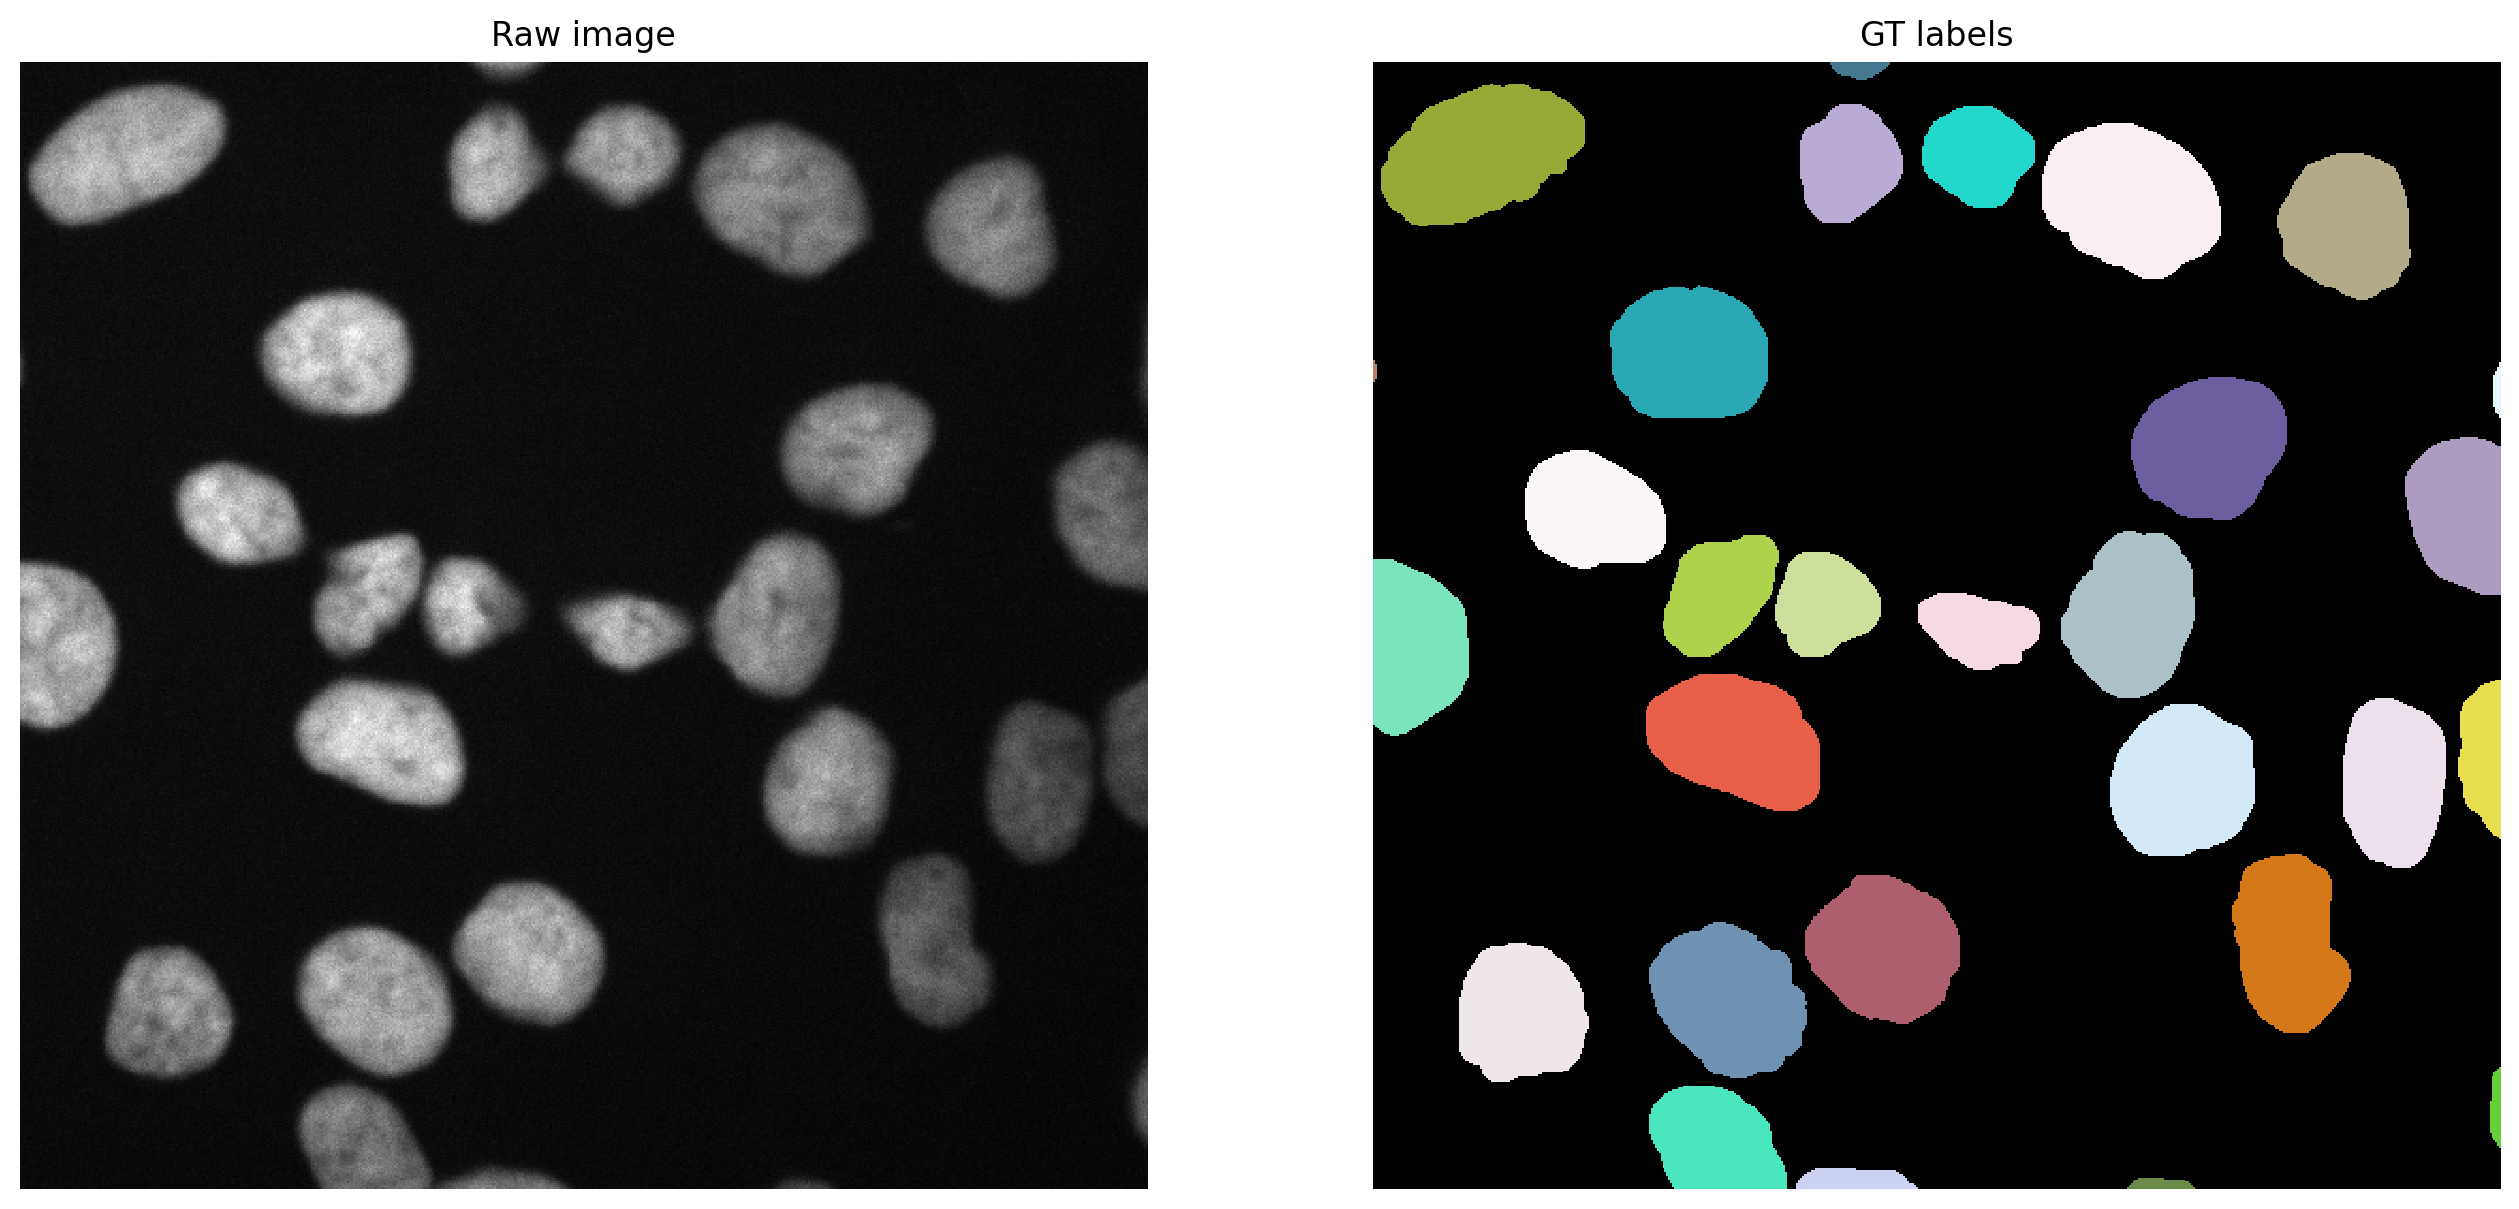

In [13]:
#plot the image

plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

# Fitting ground-truth labels with star-convex polygons

## Rays
### StarDist uses rays from a central point to map out the perimeter of the object.  The more rays coming out, the closer to actual the perimeter will be.  There is a compromise to be made though, the more rays you have, the slower the training will be

#### This will show us if the objects can be fit by star-convex polygons

In [14]:
## Generate images with different number of rays from 2^1 to 2^8

n_rays = [2**i for i in range(2,8)]
scores = []
for r in tqdm(n_rays):
    Y_reconstructed = [relabel_image_stardist(lbl, n_rays=r) for lbl in Y]
    mean_iou = matching_dataset(Y, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
    scores.append(mean_iou)

100%|█████████████████████████████████████████████| 6/6 [00:08<00:00,  1.36s/it]


## Intersection over union
 The traditional measure of the how well a label fits to a ground truth is by measuring the intersection over union. 
 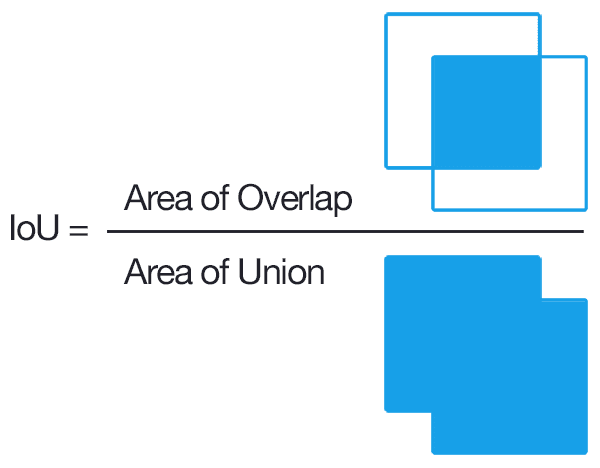

## Here we can see how well we reconstruct the ground truth labels with varying amount of rays.  Obviously four is too few rays, but as we increase the number of rays after a certain point, we get diminishing returns

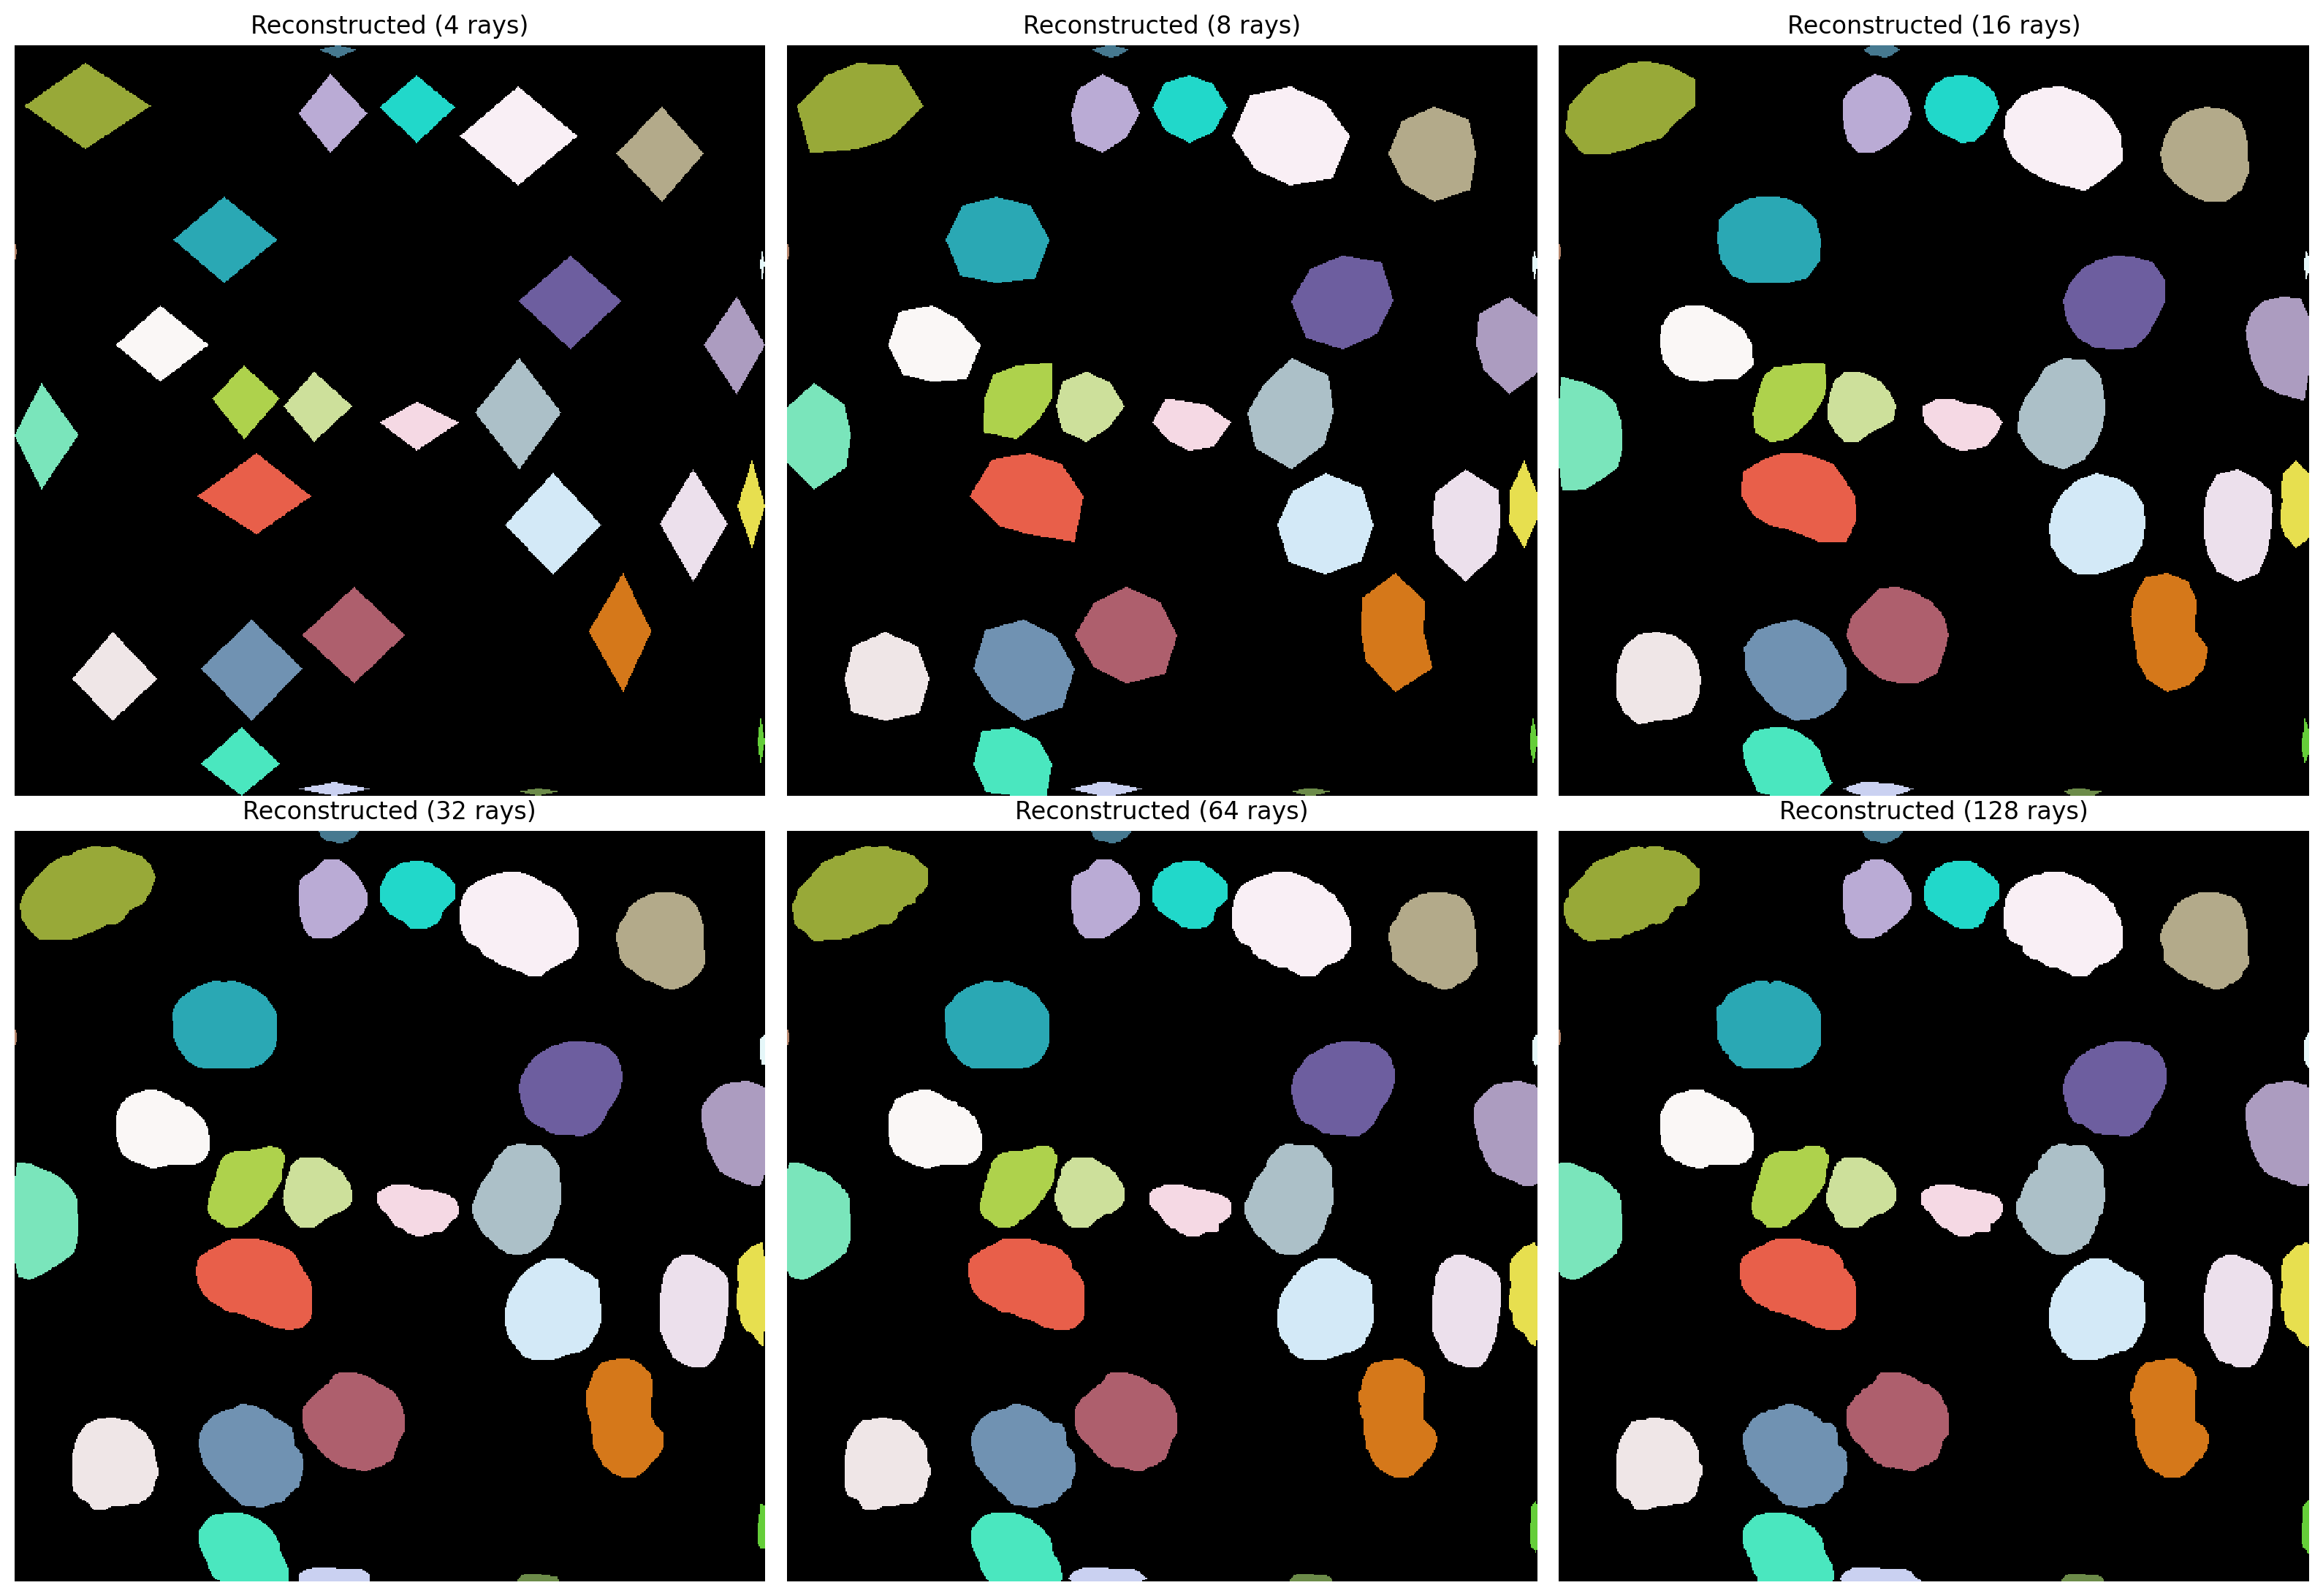

In [15]:
fig, ax = plt.subplots(2,3, figsize=(16,11))
for a,r in zip(ax.flat,n_rays):
    a.imshow(relabel_image_stardist(lbl, n_rays=r), cmap=lbl_cmap)
    a.set_title('Reconstructed (%d rays)' % r)
    a.axis('off')
plt.tight_layout();

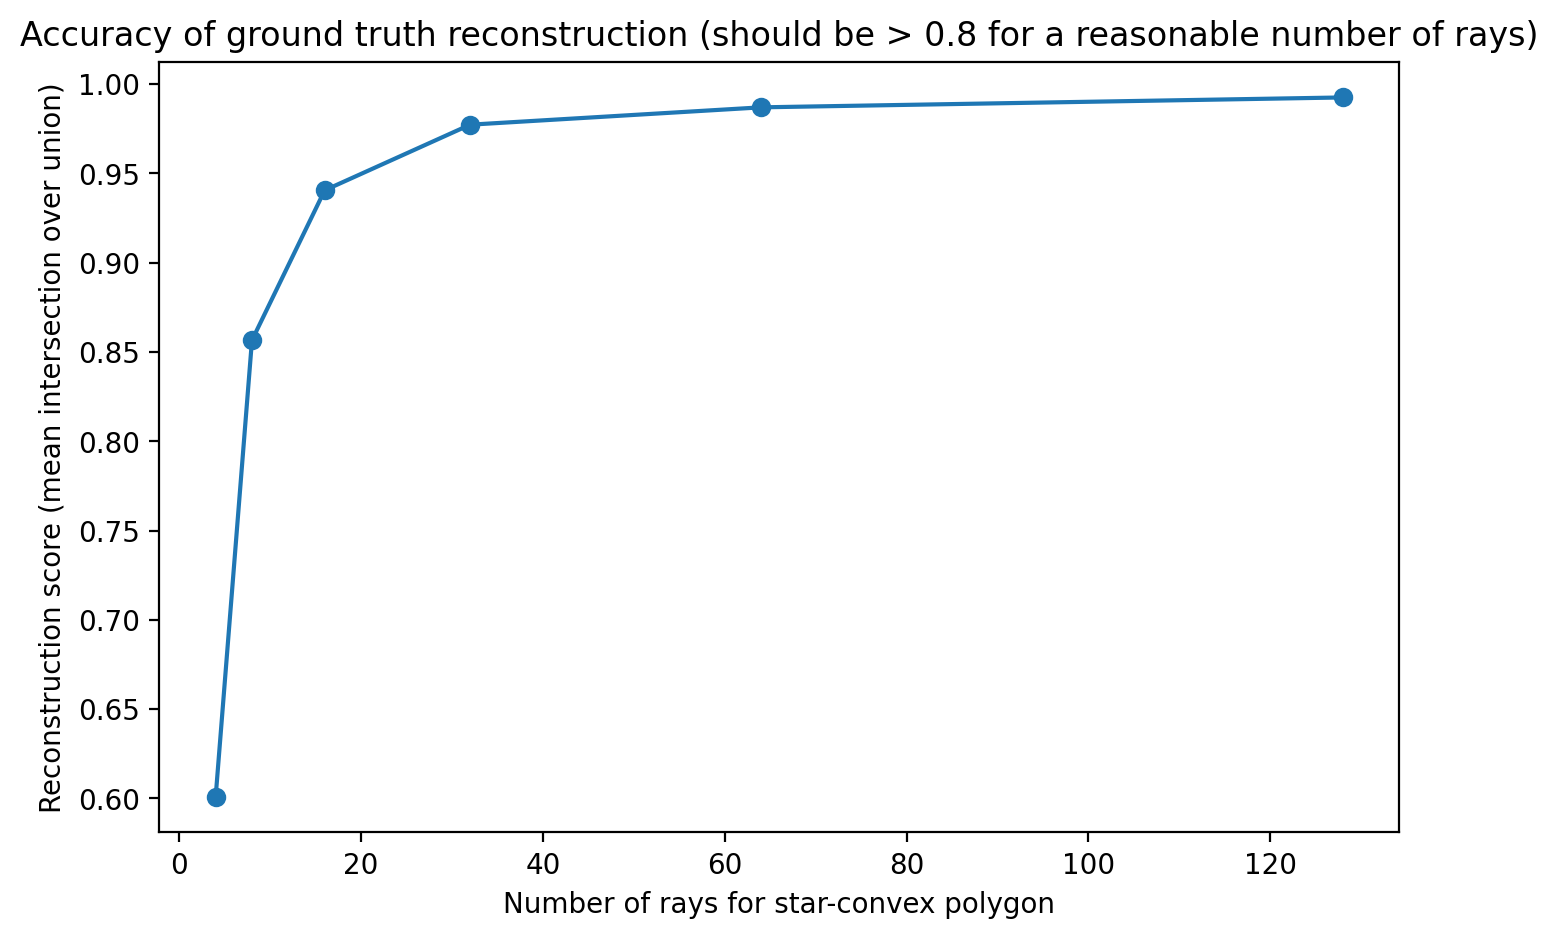

In [16]:
plt.figure(figsize=(8,5))
plt.plot(n_rays, scores, 'o-')
plt.xlabel('Number of rays for star-convex polygon')
plt.ylabel('Reconstruction score (mean intersection over union)')
plt.title("Accuracy of ground truth reconstruction (should be > 0.8 for a reasonable number of rays)")
None;

# Do the Training!
### Below is the different variables we can use to do some training. 

* Alter the number of rays based on how your images look
* If you have memory issues, change the grid size (but default is generally ok)
* Change use_gpu to True if you want to use the GPU for training (you do)
* There are a ton of other variables you can use.  One thing that is often done is transfer learning, where you can use a pre-built model and add data to it to increase it's accuracy


In [17]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32  #number of rays

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_classes=None, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_class_weights=(1, 1), train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_sample_cache=True, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', 

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


In [18]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    #limit_gpu_memory(0.8)
    # alternatively, try this:
    limit_gpu_memory(None, allow_growth=True)

2024-01-30 17:03:18.416136: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-01-30 17:03:18.427371: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:1d:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.74GiB deviceMemoryBandwidth: 836.37GiB/s
2024-01-30 17:03:18.427421: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-01-30 17:03:18.491972: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-01-30 17:03:18.492083: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2024-01-30 17:03:18.545298: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.

# Change the model name here!

**Note:** The trained `StarDist2D` model will *not* predict completed shapes for partially visible objects at the image boundary if `train_shape_completion=False` (which is the default option).

In [19]:
pwd

'/nemo/stp/lm/working/fallest/StarDist_Course_Jan_2024/notebooks_checked'

In [20]:
model_dir = '/nemo/stp/lm/working/fallest/StarDist_Course_Feb_2024/notebooks_checked/models'
if not os.path.exists(model_dir):  #make the directory if it doesn't exist
    os.makedirs(model_dir)


In [21]:
model = StarDist2D(conf, name='Crick_test', basedir=model_dir)

base_model.py (149): output path for model already exists, files may be overwritten: /nemo/stp/lm/working/fallest/StarDist_Course_Jan_2024/notebooks_checked/models/Crick_test
2024-01-30 17:03:18.690358: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-30 17:03:18.691816: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:1d:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.74GiB deviceMemoryBandwidth: 836.37GiB/s
2024-01-30 17:03:18.692382: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2024-01-30 17:03:18.692451: I tensorflow/stream_executor/platform/default/

Using default values: prob_thresh=0.5, nms_thresh=0.4.


Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [22]:
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

2024-01-30 17:03:26.227242: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-01-30 17:03:26.228736: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2400000000 Hz
2024-01-30 17:03:26.522315: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-01-30 17:03:27.674794: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8401
2024-01-30 17:03:29.374140: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-01-30 17:03:29.374793: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


median object size:      [67.  61.5]
network field of view :  [93 93]


# Data Augmentation
You can define a function/callable that applies augmentation to each batch of the data generator.  
We here use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (2D) microscopy images (but you can disable augmentation by setting `augmenter = None`).

In [23]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

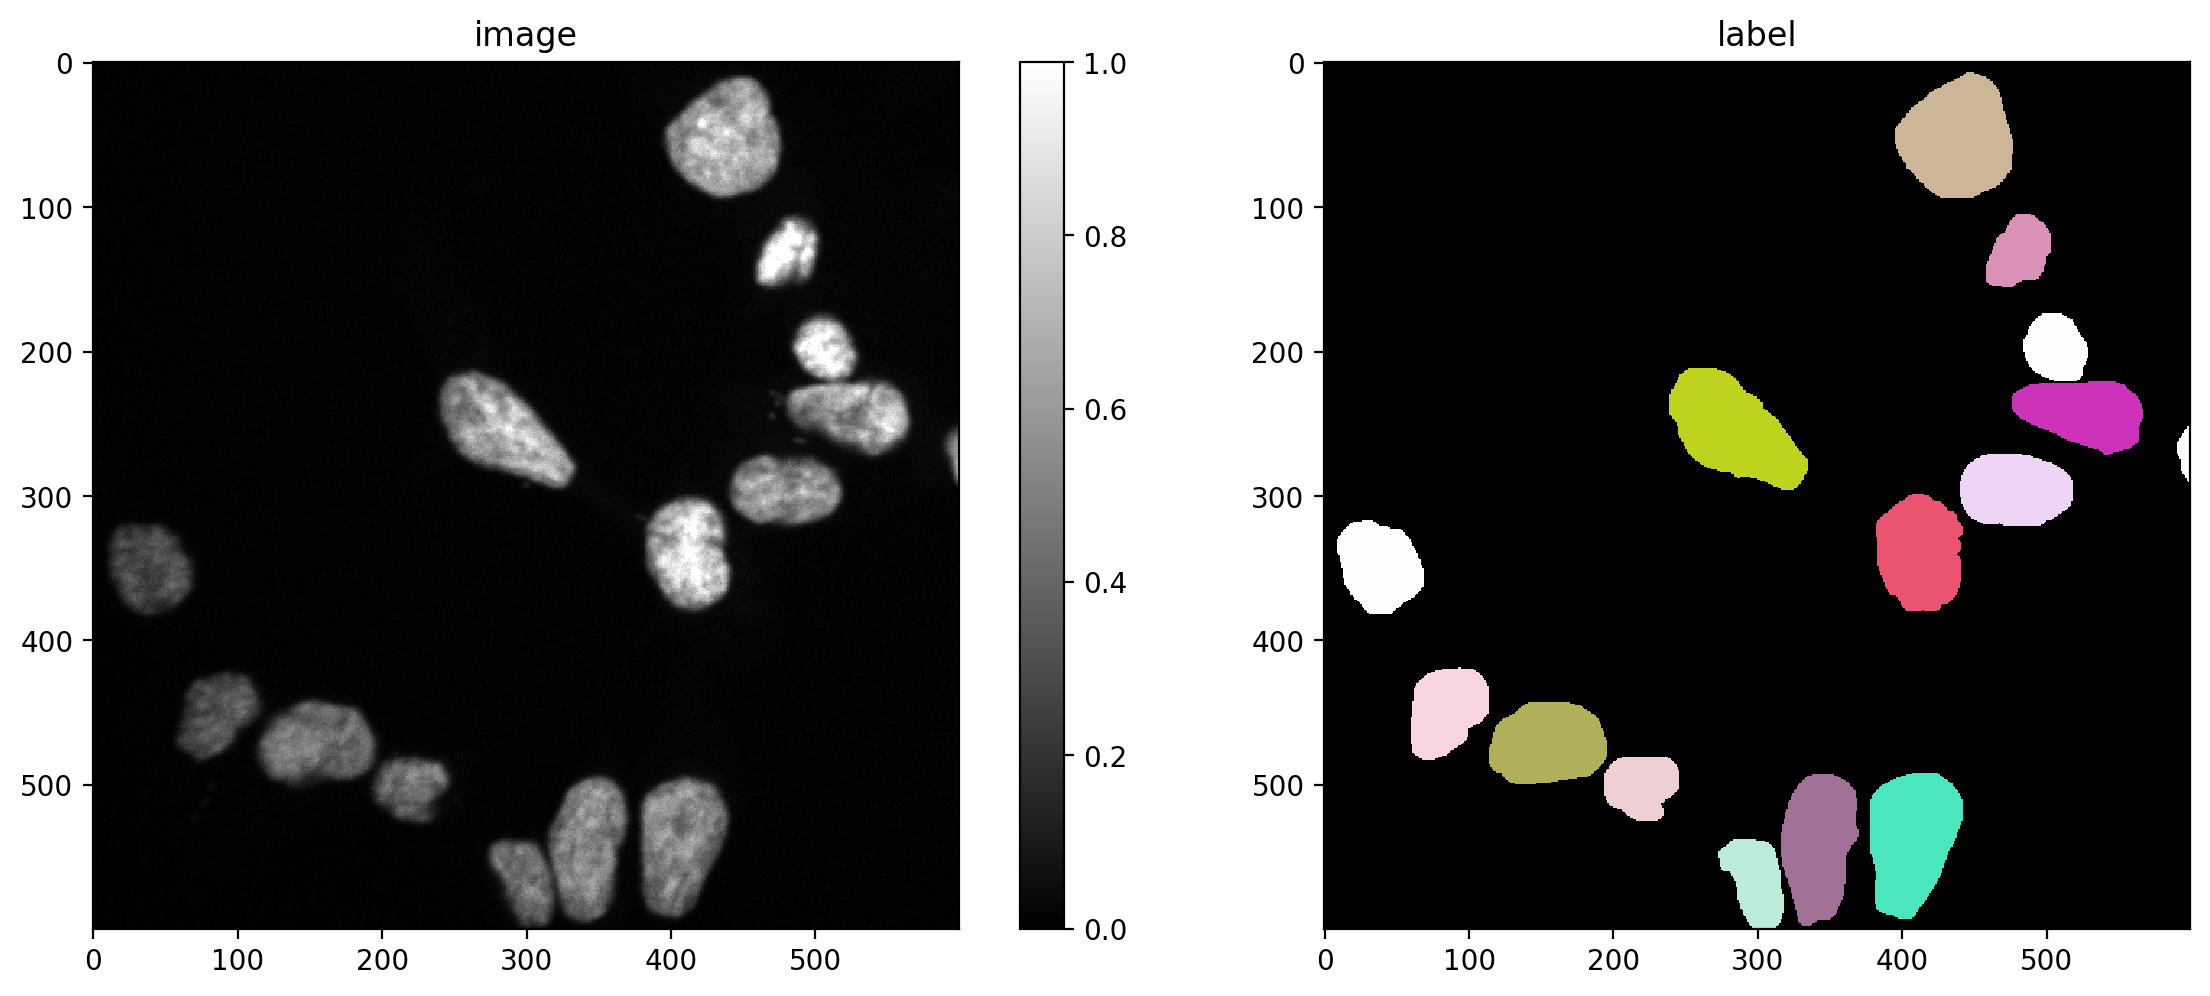

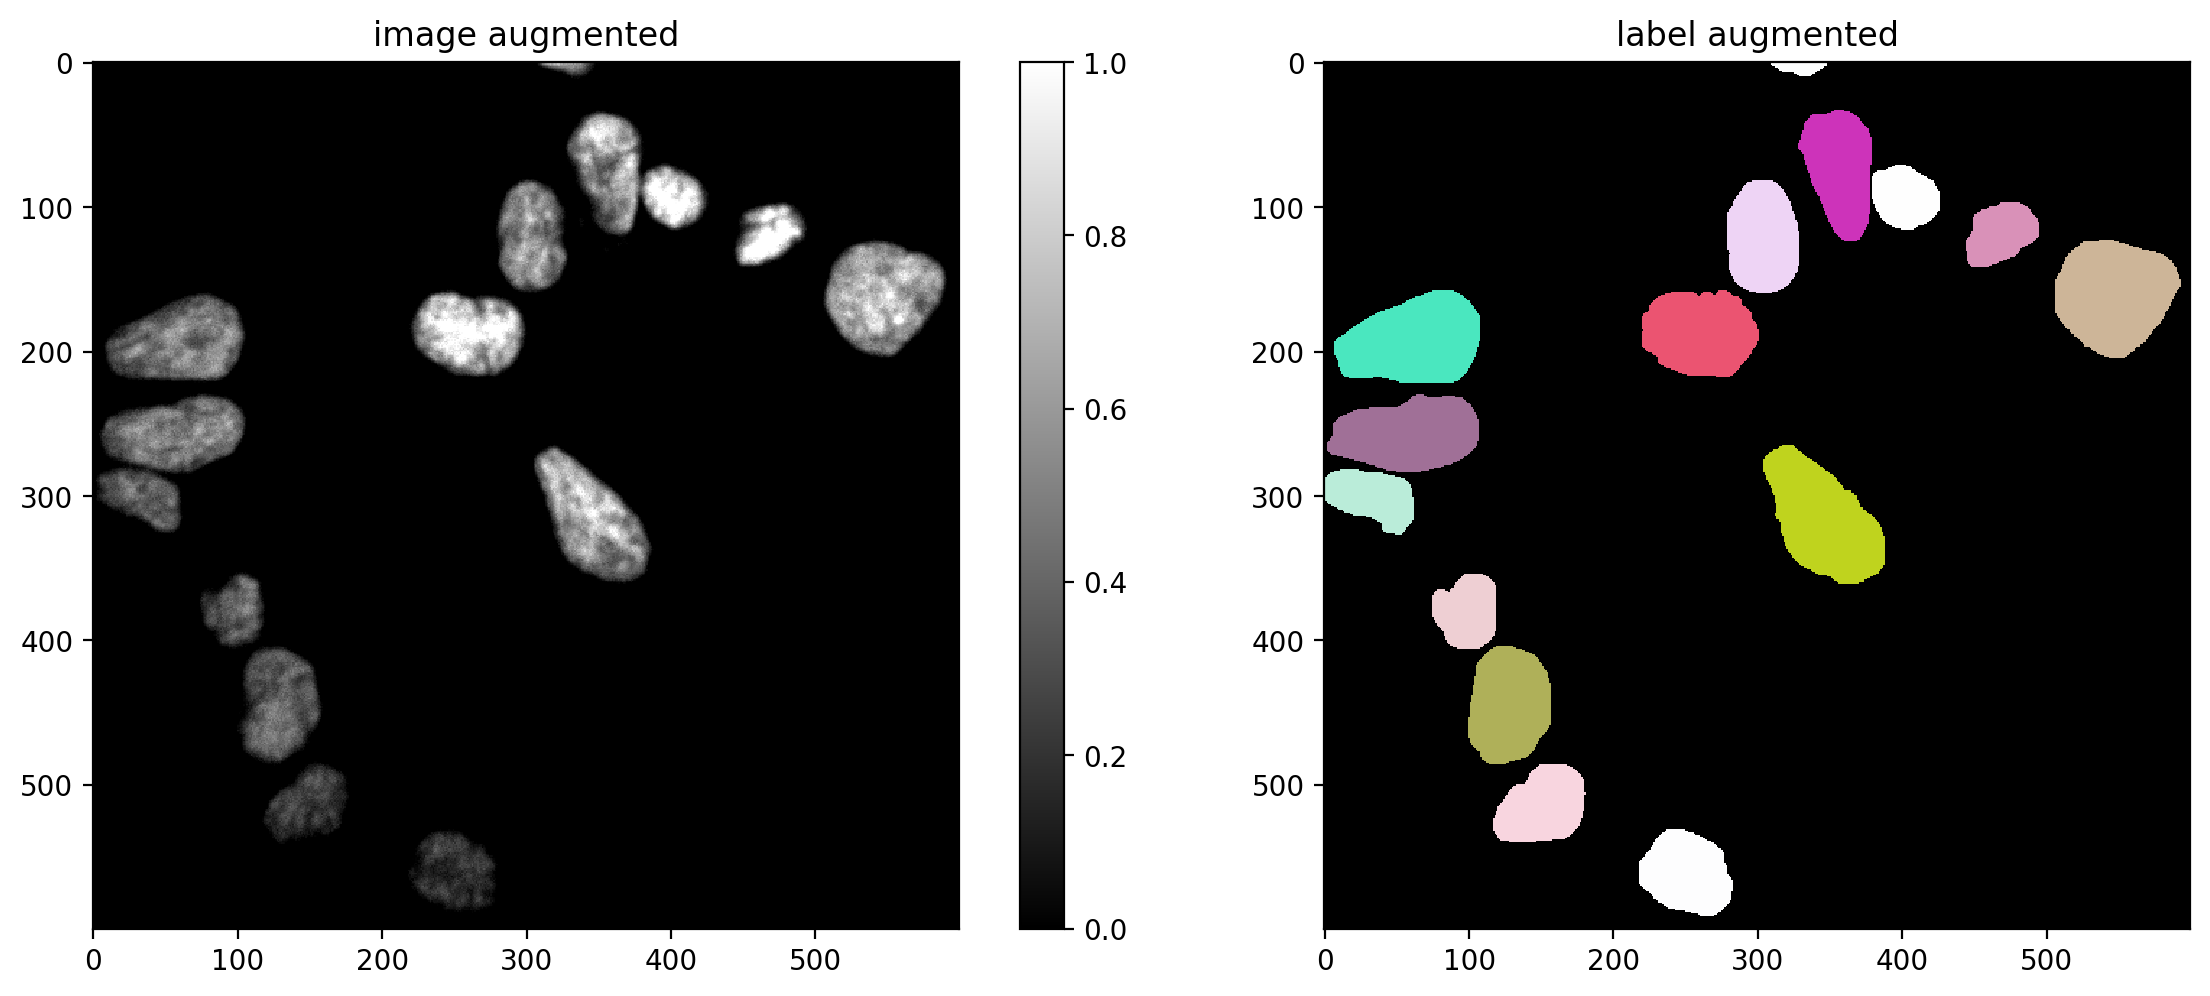

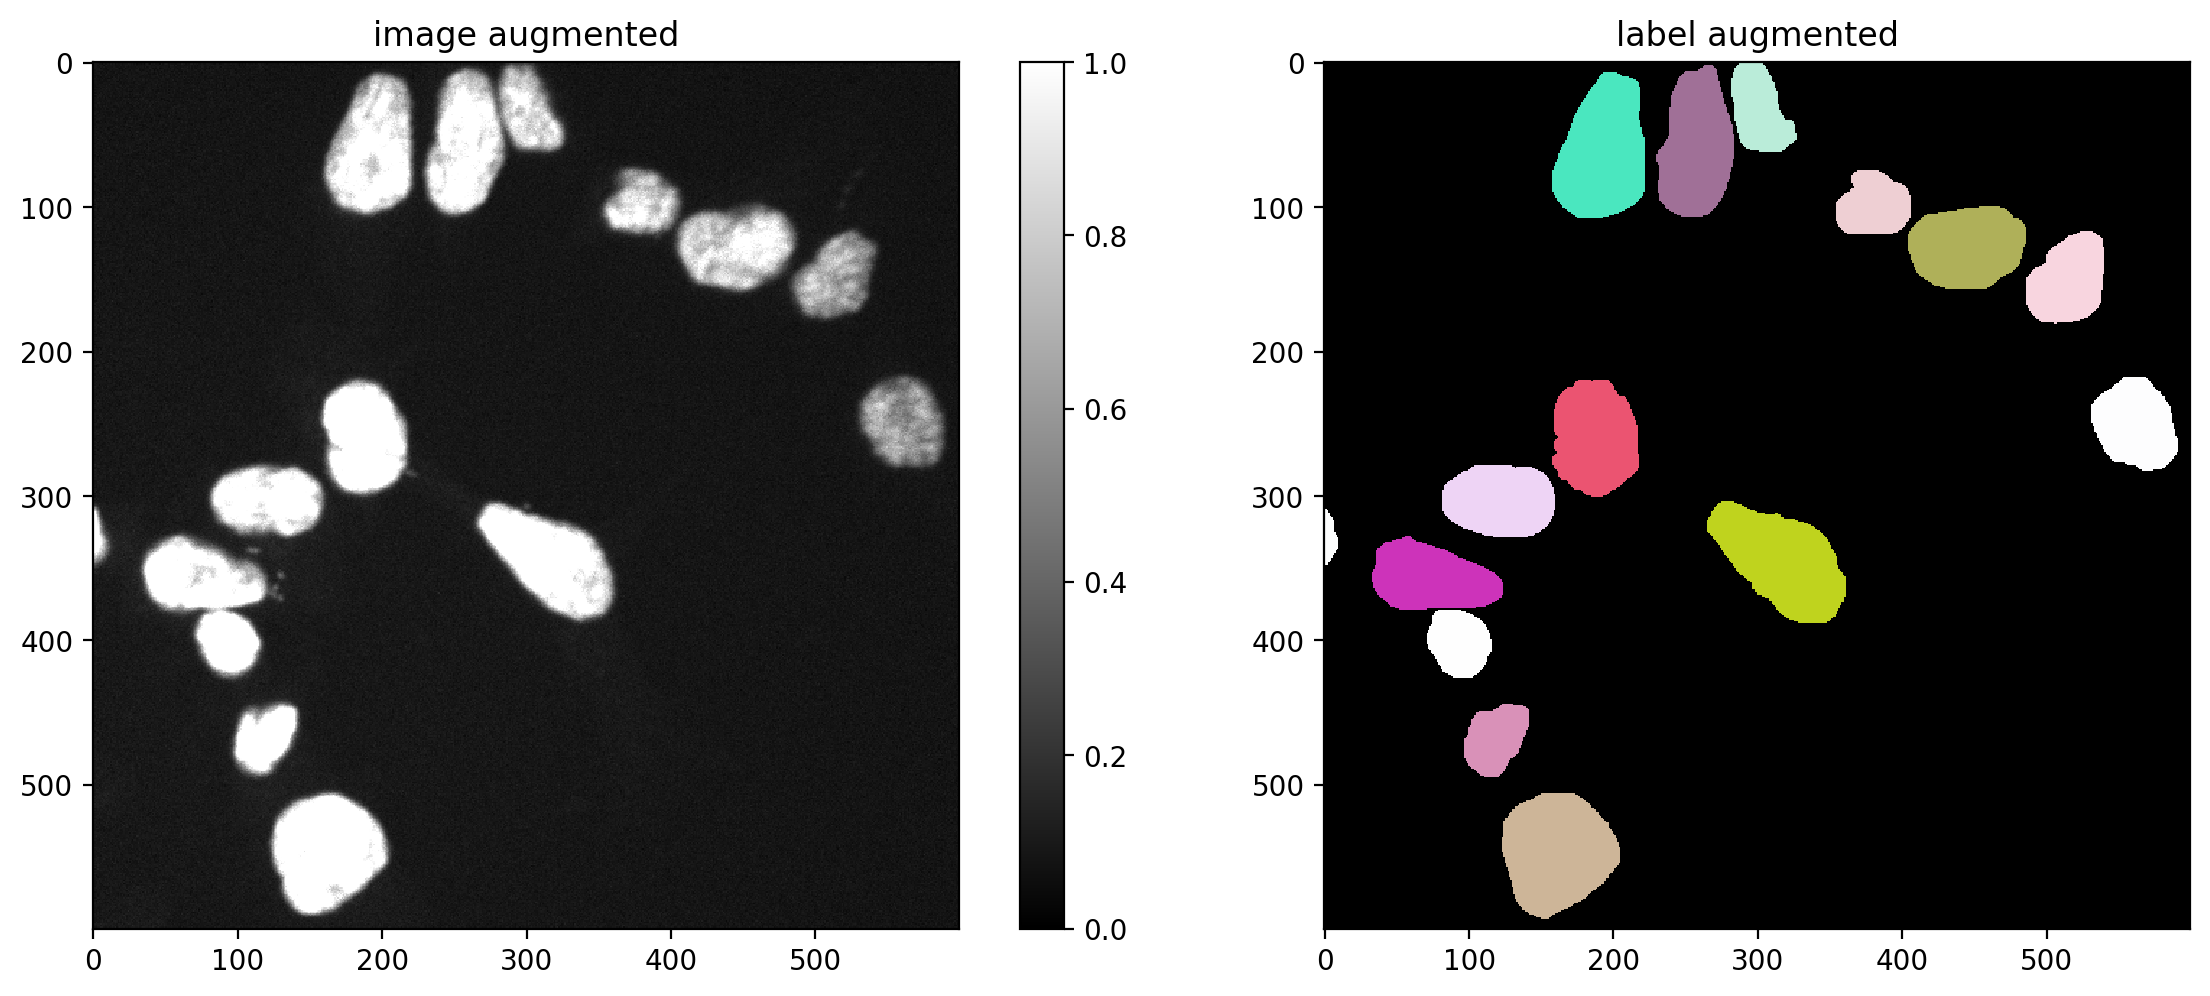

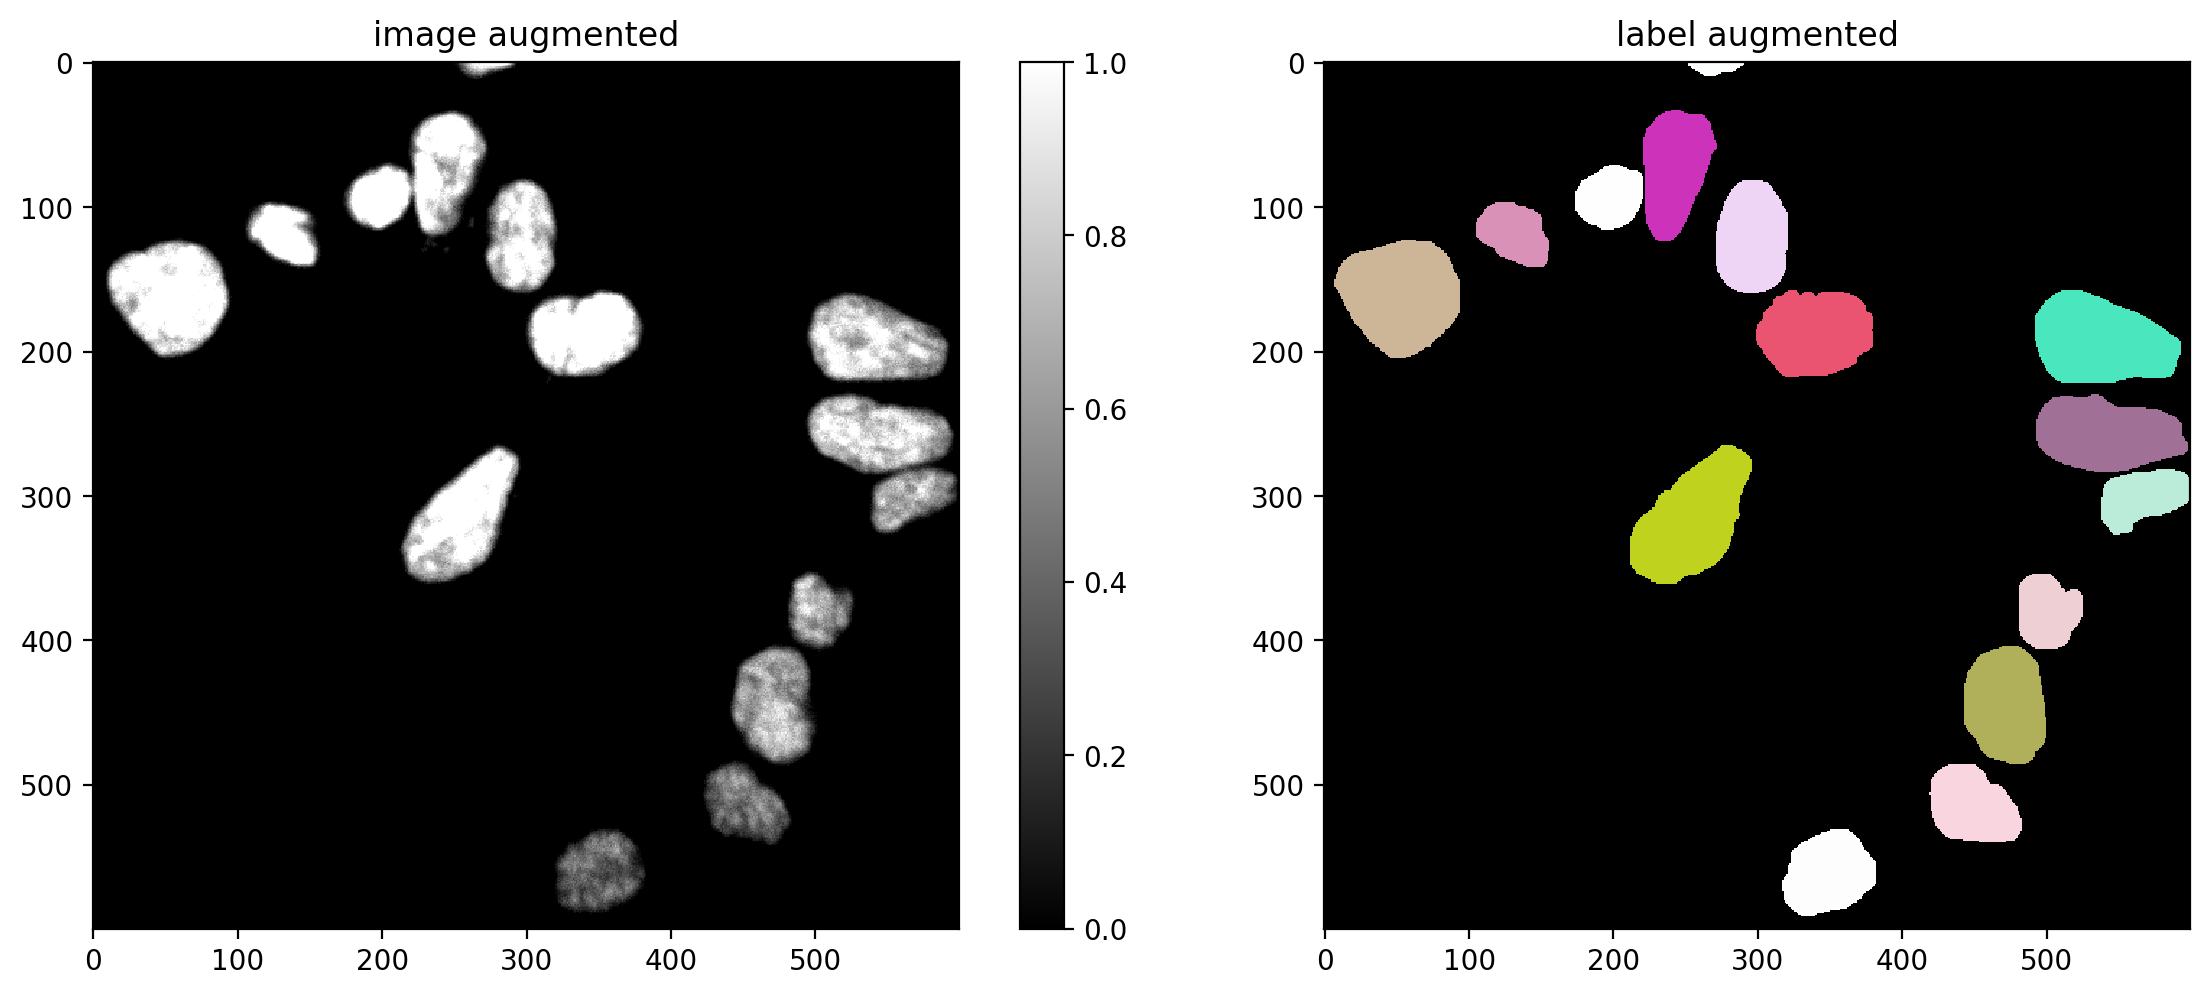

In [24]:
# plot some augmented examples
img, lbl = X[0],Y[0]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")

# Callbacks



In [25]:
from tensorflow.keras.callbacks import Callback


class EvaluateModelCallback(Callback):
    def __init__(self, validation_data, im_path):
        super(EvaluateModelCallback, self).__init__()
        self.validation_data = validation_data
        self.im_path = im_path

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            # Assuming you have a function to evaluate your model on validation data
            Y_val_pred = model.predict_instances(validation_data, n_tiles=model._guess_n_tiles(validation_data), show_tile_progress=False)[0]
            
            # Print or log the evaluation results
            print(f"\nEvaluation results at epoch {epoch}:")
            plt.imshow(validation_data, cmap='gray')
            plt.imshow(Y_val_pred, cmap=lbl_cmap, alpha=0.35)
            #im_path= '/nemo/stp/lm/working/fallest/StarDist_Course_Jan_2024/output_images/gray/'
            filename_tiff = im_path+"Labels_epoch_"+str(epoch)+"_"+model.name+".tiff"
            filename_png = im_path+"Overlay_epoch_"+str(epoch)+"_"+model.name+".png"
            print(filename_tiff)
            plt.imsave(filename_tiff, Y_val_pred, cmap=lbl_cmap)
            plt.savefig(filename_png)
            


In [26]:
#Set the image we want to use for the callback, and the path we want to save the images to
validation_data = X_val[0]
im_path= '/nemo/stp/lm/working/fallest/StarDist_Course_Feb_2024/output_images/Crick_Images/'

if not os.path.exists(im_path):  #make the directory if it doesn't exist
    os.makedirs(im_path)



evaluate_callback = EvaluateModelCallback(validation_data, im_path) #set up the callback with the image and the path

# Training

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function _gcd_import at 0x7fefeed30430>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function _gcd_import at 0x7fefeed30430>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function _gcd_import at 0x7fefeed30430>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
20/20 [==============================] - 4s 66ms/step - loss: 6.3494 - prob_loss: 0.5420 - dist_loss: 29.0371 - prob_kld: 0.4335 - dist_relevant_mae: 29.0371 - dist_relevant_mse: 1128.2830 - dist_dist_iou_metric: 2.3021e-04 - val_loss: 5.5023 - val_prob_loss: 0.4544 - val_dist_loss: 25.2399 - val_prob_kld: 0.2765 - val_dist_relev

Epoch 18/200
20/20 [==============================] - 1s 45ms/step - loss: 1.3655 - prob_loss: 0.1594 - dist_loss: 6.0305 - prob_kld: 0.0543 - dist_relevant_mae: 6.0291 - dist_relevant_mse: 78.9289 - dist_dist_iou_metric: 0.6375 - val_loss: 1.0282 - val_prob_loss: 0.2292 - val_dist_loss: 3.9949 - val_prob_kld: 0.0514 - val_dist_relevant_mae: 3.9934 - val_dist_relevant_mse: 32.2792 - val_dist_dist_iou_metric: 0.7431
Epoch 19/200
20/20 [==============================] - 1s 44ms/step - loss: 1.2486 - prob_loss: 0.1486 - dist_loss: 5.5000 - prob_kld: 0.0451 - dist_relevant_mae: 5.4985 - dist_relevant_mse: 65.1583 - dist_dist_iou_metric: 0.6667 - val_loss: 1.0413 - val_prob_loss: 0.2052 - val_dist_loss: 4.1806 - val_prob_kld: 0.0273 - val_dist_relevant_mae: 4.1792 - val_dist_relevant_mse: 32.9953 - val_dist_dist_iou_metric: 0.7423
Epoch 20/200
20/20 [==============================] - 1s 47ms/step - loss: 1.2703 - prob_loss: 0.1489 - dist_loss: 5.6074 - prob_kld: 0.0417 - dist_relevant_mae: 

Epoch 37/200
20/20 [==============================] - 1s 45ms/step - loss: 1.0719 - prob_loss: 0.1244 - dist_loss: 4.7374 - prob_kld: 0.0166 - dist_relevant_mae: 4.7361 - dist_relevant_mse: 47.1868 - dist_dist_iou_metric: 0.7057 - val_loss: 0.8105 - val_prob_loss: 0.1950 - val_dist_loss: 3.0775 - val_prob_kld: 0.0172 - val_dist_relevant_mae: 3.0761 - val_dist_relevant_mse: 20.1941 - val_dist_dist_iou_metric: 0.7884
Epoch 38/200
20/20 [==============================] - 1s 46ms/step - loss: 1.0229 - prob_loss: 0.1198 - dist_loss: 4.5151 - prob_kld: 0.0161 - dist_relevant_mae: 4.5139 - dist_relevant_mse: 44.9633 - dist_dist_iou_metric: 0.7055 - val_loss: 0.8537 - val_prob_loss: 0.1948 - val_dist_loss: 3.2945 - val_prob_kld: 0.0170 - val_dist_relevant_mae: 3.2931 - val_dist_relevant_mse: 20.3356 - val_dist_dist_iou_metric: 0.7883
Epoch 39/200
20/20 [==============================] - 1s 45ms/step - loss: 1.0283 - prob_loss: 0.1271 - dist_loss: 4.5063 - prob_kld: 0.0160 - dist_relevant_mae: 

Epoch 56/200
20/20 [==============================] - 1s 46ms/step - loss: 0.8674 - prob_loss: 0.1220 - dist_loss: 3.7272 - prob_kld: 0.0151 - dist_relevant_mae: 3.7260 - dist_relevant_mse: 31.8575 - dist_dist_iou_metric: 0.7613 - val_loss: 0.7326 - val_prob_loss: 0.1967 - val_dist_loss: 2.6793 - val_prob_kld: 0.0189 - val_dist_relevant_mae: 2.6781 - val_dist_relevant_mse: 14.3139 - val_dist_dist_iou_metric: 0.8127
Epoch 57/200
20/20 [==============================] - 1s 45ms/step - loss: 0.8830 - prob_loss: 0.1239 - dist_loss: 3.7958 - prob_kld: 0.0142 - dist_relevant_mae: 3.7947 - dist_relevant_mse: 32.8471 - dist_dist_iou_metric: 0.7633 - val_loss: 0.7633 - val_prob_loss: 0.1981 - val_dist_loss: 2.8259 - val_prob_kld: 0.0203 - val_dist_relevant_mae: 2.8246 - val_dist_relevant_mse: 14.4776 - val_dist_dist_iou_metric: 0.8203
Epoch 58/200
20/20 [==============================] - 1s 46ms/step - loss: 0.8556 - prob_loss: 0.1277 - dist_loss: 3.6393 - prob_kld: 0.0187 - dist_relevant_mae: 

Epoch 75/200
20/20 [==============================] - 1s 46ms/step - loss: 0.7718 - prob_loss: 0.1223 - dist_loss: 3.2472 - prob_kld: 0.0141 - dist_relevant_mae: 3.2460 - dist_relevant_mse: 24.2960 - dist_dist_iou_metric: 0.7894 - val_loss: 0.6641 - val_prob_loss: 0.1933 - val_dist_loss: 2.3540 - val_prob_kld: 0.0155 - val_dist_relevant_mae: 2.3527 - val_dist_relevant_mse: 10.6388 - val_dist_dist_iou_metric: 0.8403
Epoch 76/200
20/20 [==============================] - 1s 45ms/step - loss: 0.7390 - prob_loss: 0.1132 - dist_loss: 3.1293 - prob_kld: 0.0117 - dist_relevant_mae: 3.1282 - dist_relevant_mse: 22.4241 - dist_dist_iou_metric: 0.7957 - val_loss: 0.6484 - val_prob_loss: 0.1962 - val_dist_loss: 2.2609 - val_prob_kld: 0.0184 - val_dist_relevant_mae: 2.2597 - val_dist_relevant_mse: 9.9598 - val_dist_dist_iou_metric: 0.8463
Epoch 77/200
20/20 [==============================] - 1s 44ms/step - loss: 0.7297 - prob_loss: 0.1109 - dist_loss: 3.0940 - prob_kld: 0.0115 - dist_relevant_mae: 3

Epoch 94/200
20/20 [==============================] - 1s 44ms/step - loss: 0.6981 - prob_loss: 0.1160 - dist_loss: 2.9103 - prob_kld: 0.0112 - dist_relevant_mae: 2.9094 - dist_relevant_mse: 18.6046 - dist_dist_iou_metric: 0.8106 - val_loss: 0.6290 - val_prob_loss: 0.1932 - val_dist_loss: 2.1792 - val_prob_kld: 0.0154 - val_dist_relevant_mae: 2.1781 - val_dist_relevant_mse: 9.7635 - val_dist_dist_iou_metric: 0.8450
Epoch 95/200
20/20 [==============================] - 1s 44ms/step - loss: 0.6605 - prob_loss: 0.1120 - dist_loss: 2.7428 - prob_kld: 0.0112 - dist_relevant_mae: 2.7419 - dist_relevant_mse: 16.9649 - dist_dist_iou_metric: 0.8177 - val_loss: 0.5923 - val_prob_loss: 0.1904 - val_dist_loss: 2.0095 - val_prob_kld: 0.0126 - val_dist_relevant_mae: 2.0084 - val_dist_relevant_mse: 8.3132 - val_dist_dist_iou_metric: 0.8586
Epoch 96/200
20/20 [==============================] - 1s 45ms/step - loss: 0.6813 - prob_loss: 0.1130 - dist_loss: 2.8414 - prob_kld: 0.0118 - dist_relevant_mae: 2.

Epoch 113/200
20/20 [==============================] - 1s 45ms/step - loss: 0.6213 - prob_loss: 0.1182 - dist_loss: 2.5155 - prob_kld: 0.0104 - dist_relevant_mae: 2.5146 - dist_relevant_mse: 13.7643 - dist_dist_iou_metric: 0.8354 - val_loss: 0.5757 - val_prob_loss: 0.1903 - val_dist_loss: 1.9266 - val_prob_kld: 0.0125 - val_dist_relevant_mae: 1.9256 - val_dist_relevant_mse: 7.6741 - val_dist_dist_iou_metric: 0.8655
Epoch 114/200
20/20 [==============================] - 1s 45ms/step - loss: 0.6315 - prob_loss: 0.1133 - dist_loss: 2.5909 - prob_kld: 0.0097 - dist_relevant_mae: 2.5901 - dist_relevant_mse: 15.4701 - dist_dist_iou_metric: 0.8280 - val_loss: 0.5762 - val_prob_loss: 0.1909 - val_dist_loss: 1.9262 - val_prob_kld: 0.0131 - val_dist_relevant_mae: 1.9252 - val_dist_relevant_mse: 7.8008 - val_dist_dist_iou_metric: 0.8637
Epoch 115/200
20/20 [==============================] - 1s 45ms/step - loss: 0.6399 - prob_loss: 0.1208 - dist_loss: 2.5952 - prob_kld: 0.0120 - dist_relevant_mae:

Epoch 132/200
20/20 [==============================] - 1s 46ms/step - loss: 0.6107 - prob_loss: 0.1146 - dist_loss: 2.4801 - prob_kld: 0.0092 - dist_relevant_mae: 2.4792 - dist_relevant_mse: 13.1766 - dist_dist_iou_metric: 0.8384 - val_loss: 0.5479 - val_prob_loss: 0.1900 - val_dist_loss: 1.7896 - val_prob_kld: 0.0122 - val_dist_relevant_mae: 1.7885 - val_dist_relevant_mse: 6.4148 - val_dist_dist_iou_metric: 0.8752
Epoch 133/200
20/20 [==============================] - 1s 45ms/step - loss: 0.5999 - prob_loss: 0.1224 - dist_loss: 2.3879 - prob_kld: 0.0108 - dist_relevant_mae: 2.3870 - dist_relevant_mse: 12.6973 - dist_dist_iou_metric: 0.8439 - val_loss: 0.5550 - val_prob_loss: 0.1905 - val_dist_loss: 1.8225 - val_prob_kld: 0.0127 - val_dist_relevant_mae: 1.8214 - val_dist_relevant_mse: 6.5626 - val_dist_dist_iou_metric: 0.8733
Epoch 134/200
20/20 [==============================] - 1s 47ms/step - loss: 0.5847 - prob_loss: 0.1088 - dist_loss: 2.3793 - prob_kld: 0.0087 - dist_relevant_mae:

20/20 [==============================] - 1s 46ms/step - loss: 0.5986 - prob_loss: 0.1186 - dist_loss: 2.3997 - prob_kld: 0.0096 - dist_relevant_mae: 2.3988 - dist_relevant_mse: 12.2785 - dist_dist_iou_metric: 0.8448 - val_loss: 0.5878 - val_prob_loss: 0.1909 - val_dist_loss: 1.9849 - val_prob_kld: 0.0131 - val_dist_relevant_mae: 1.9838 - val_dist_relevant_mse: 7.0970 - val_dist_dist_iou_metric: 0.8679

Evaluation results at epoch 150:
/nemo/stp/lm/working/fallest/StarDist_Course_Feb_2024/output_images/Crick_Images/Labels_epoch_150_Crick_test.tiff
Epoch 152/200
20/20 [==============================] - 1s 45ms/step - loss: 0.5910 - prob_loss: 0.1185 - dist_loss: 2.3628 - prob_kld: 0.0099 - dist_relevant_mae: 2.3620 - dist_relevant_mse: 12.0879 - dist_dist_iou_metric: 0.8464 - val_loss: 0.5214 - val_prob_loss: 0.1892 - val_dist_loss: 1.6612 - val_prob_kld: 0.0114 - val_dist_relevant_mae: 1.6602 - val_dist_relevant_mse: 5.4810 - val_dist_dist_iou_metric: 0.8849
Epoch 153/200
20/20 [=======

Epoch 170/200
20/20 [==============================] - 1s 47ms/step - loss: 0.5664 - prob_loss: 0.1135 - dist_loss: 2.2645 - prob_kld: 0.0086 - dist_relevant_mae: 2.2637 - dist_relevant_mse: 11.1622 - dist_dist_iou_metric: 0.8539 - val_loss: 0.5207 - val_prob_loss: 0.1887 - val_dist_loss: 1.6603 - val_prob_kld: 0.0109 - val_dist_relevant_mae: 1.6593 - val_dist_relevant_mse: 5.2442 - val_dist_dist_iou_metric: 0.8856
Epoch 171/200
20/20 [==============================] - 1s 45ms/step - loss: 0.5668 - prob_loss: 0.1111 - dist_loss: 2.2783 - prob_kld: 0.0085 - dist_relevant_mae: 2.2775 - dist_relevant_mse: 11.5645 - dist_dist_iou_metric: 0.8546 - val_loss: 0.5627 - val_prob_loss: 0.1878 - val_dist_loss: 1.8746 - val_prob_kld: 0.0100 - val_dist_relevant_mae: 1.8736 - val_dist_relevant_mse: 6.8165 - val_dist_dist_iou_metric: 0.8674

Evaluation results at epoch 170:
/nemo/stp/lm/working/fallest/StarDist_Course_Feb_2024/output_images/Crick_Images/Labels_epoch_170_Crick_test.tiff
Epoch 172/200


Epoch 189/200
20/20 [==============================] - 1s 45ms/step - loss: 0.5586 - prob_loss: 0.1142 - dist_loss: 2.2220 - prob_kld: 0.0082 - dist_relevant_mae: 2.2212 - dist_relevant_mse: 10.5778 - dist_dist_iou_metric: 0.8591 - val_loss: 0.5971 - val_prob_loss: 0.1884 - val_dist_loss: 2.0436 - val_prob_kld: 0.0106 - val_dist_relevant_mae: 2.0427 - val_dist_relevant_mse: 7.6846 - val_dist_dist_iou_metric: 0.8576
Epoch 190/200
20/20 [==============================] - 1s 47ms/step - loss: 0.5465 - prob_loss: 0.1171 - dist_loss: 2.1471 - prob_kld: 0.0087 - dist_relevant_mae: 2.1463 - dist_relevant_mse: 10.2482 - dist_dist_iou_metric: 0.8598 - val_loss: 0.5135 - val_prob_loss: 0.1878 - val_dist_loss: 1.6285 - val_prob_kld: 0.0100 - val_dist_relevant_mae: 1.6276 - val_dist_relevant_mse: 5.0719 - val_dist_dist_iou_metric: 0.8882
Epoch 191/200
20/20 [==============================] - 1s 45ms/step - loss: 0.5460 - prob_loss: 0.1128 - dist_loss: 2.1659 - prob_kld: 0.0080 - dist_relevant_mae:

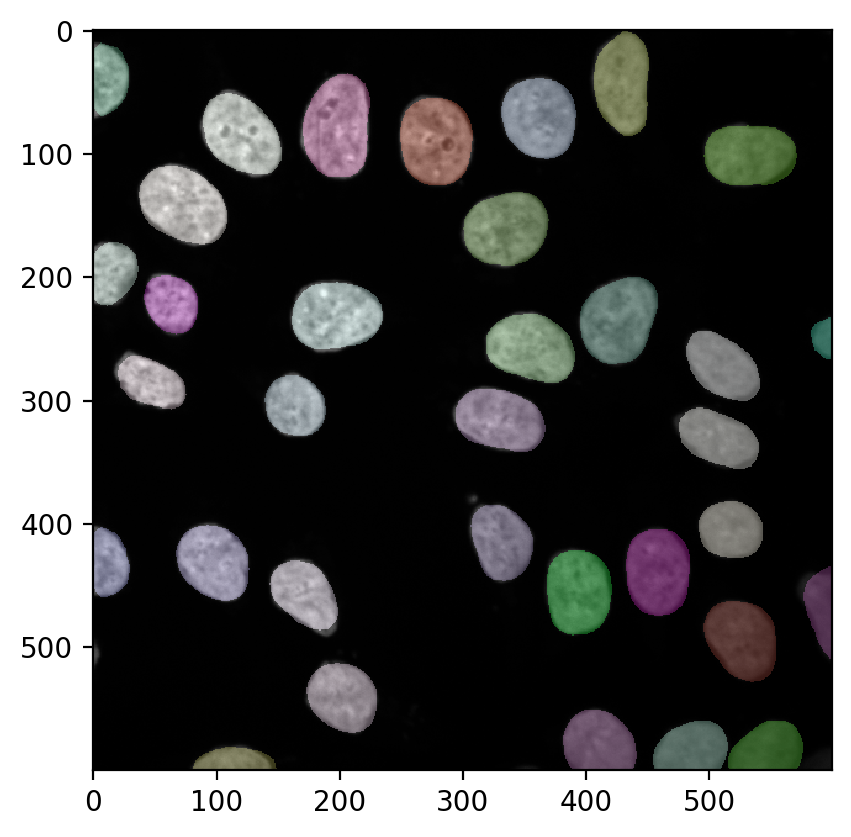

In [27]:
quick_demo = False
export_epoch_images = True

if quick_demo==False:
    epochs=200
    steps=20


if quick_demo:
    print (
        "NOTE: This is only for a quick demonstration!\n"
        "      Please set the variable 'quick_demo = False' for proper (long) training.",
        file=sys.stderr, flush=True
    )
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=2, steps_per_epoch=10)

    print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
    model = StarDist2D.from_pretrained('2D_demo')
else:
    if export_epoch_images==False:
        model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter, epochs=epochs, steps_per_epoch=steps)
    else:
        model.prepare_for_training() # open up the model for adding callbacks
        model.callbacks.append(evaluate_callback) #add our callback
        model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter, epochs=epochs, steps_per_epoch=steps)
None;

In [28]:
if quick_demo:
    model.optimize_thresholds(X_val[:2], Y_val[:2])
else:
    model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|████▌ | 15/20 [00:01<00:00, 14.25it/s, 0.604 -> 0.895]


Using optimized values: prob_thresh=0.601403, nms_thresh=0.3.
Saving to 'thresholds.json'.


# Evaluation and Detection Performance
Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index)) beyond a chosen IoU threshold $\tau$.


The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function). 

### Tau: Tau is the IoU threshold.  

### The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.

Please see `help(matching)` for definitions of the abbreviations used in the evaluation below and see the Wikipedia page on [Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for further details.

In [29]:
#help(matching)

## First predict the labels for all validation images:

In [30]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


Plot a GT/prediction example 

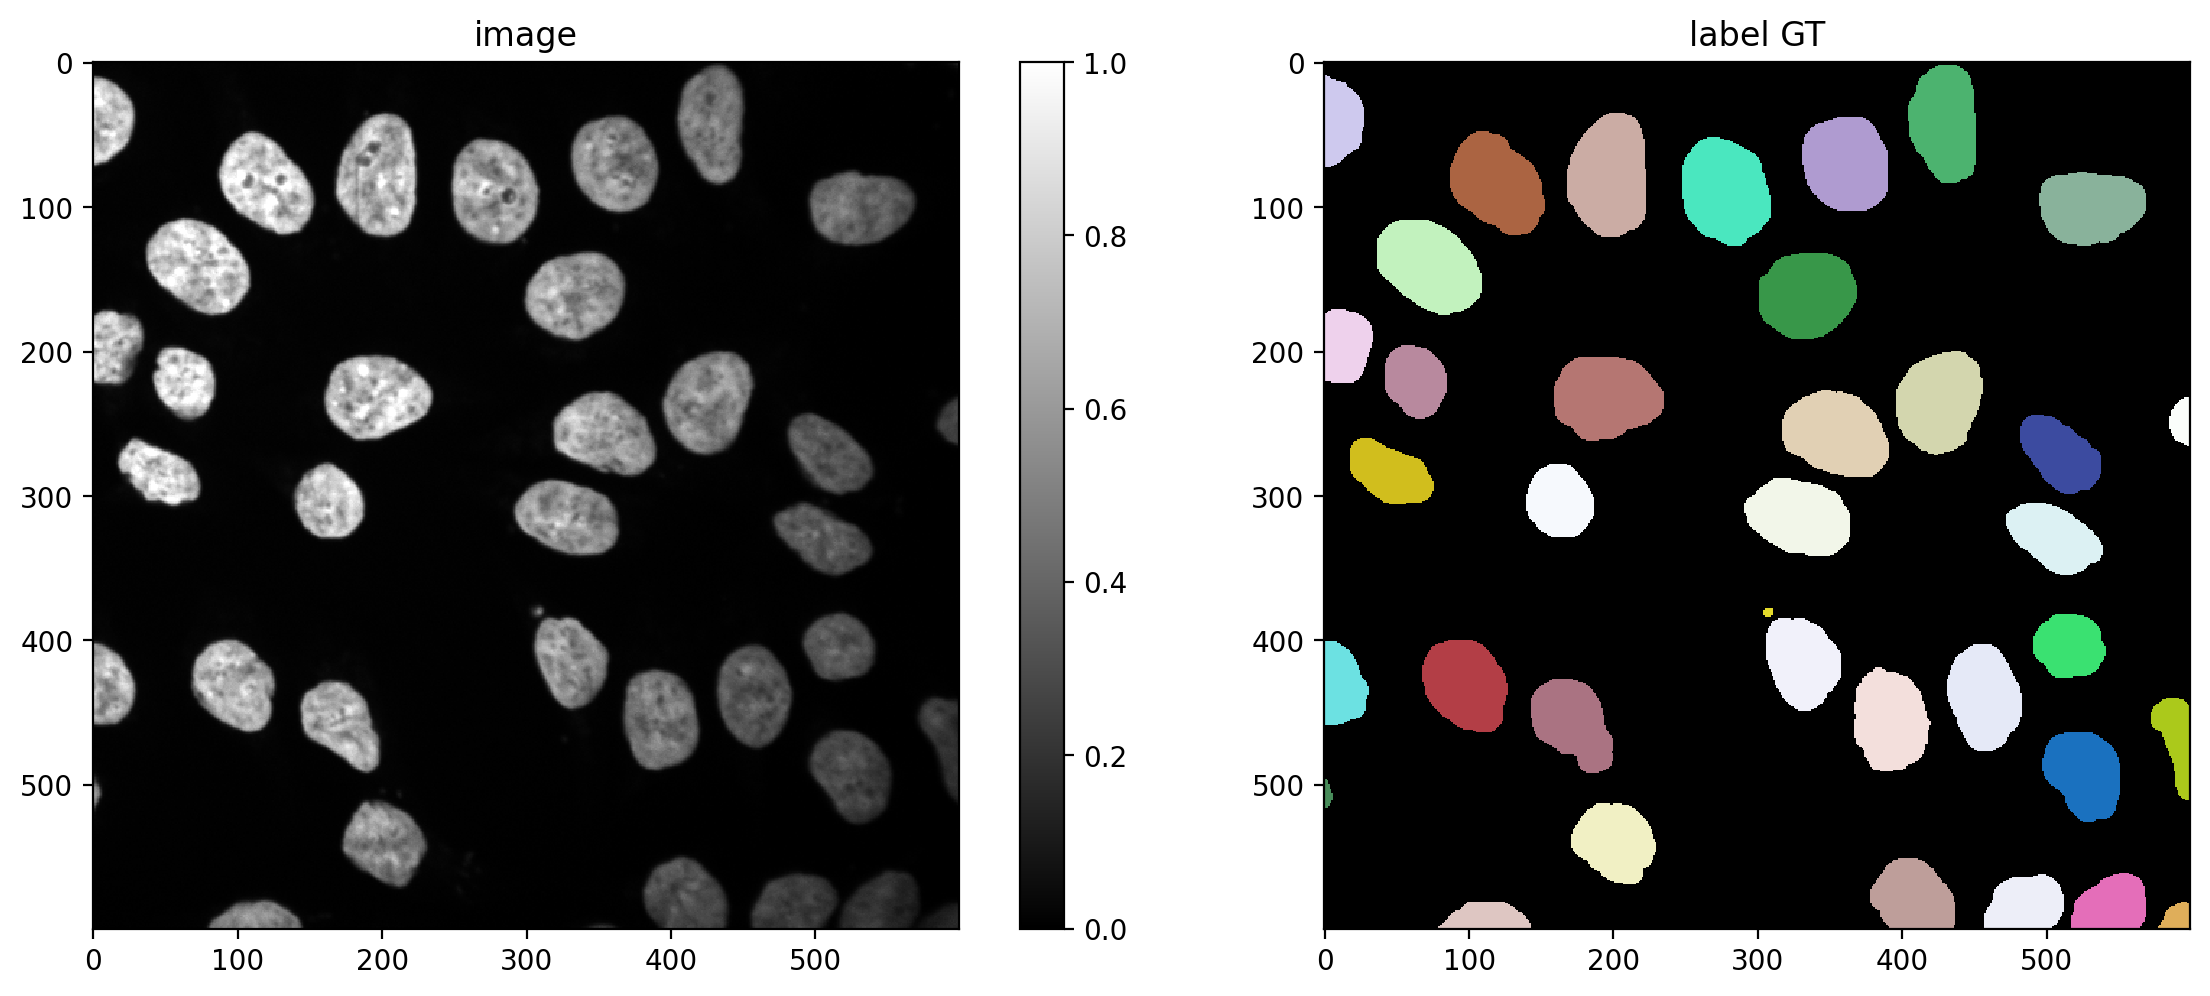

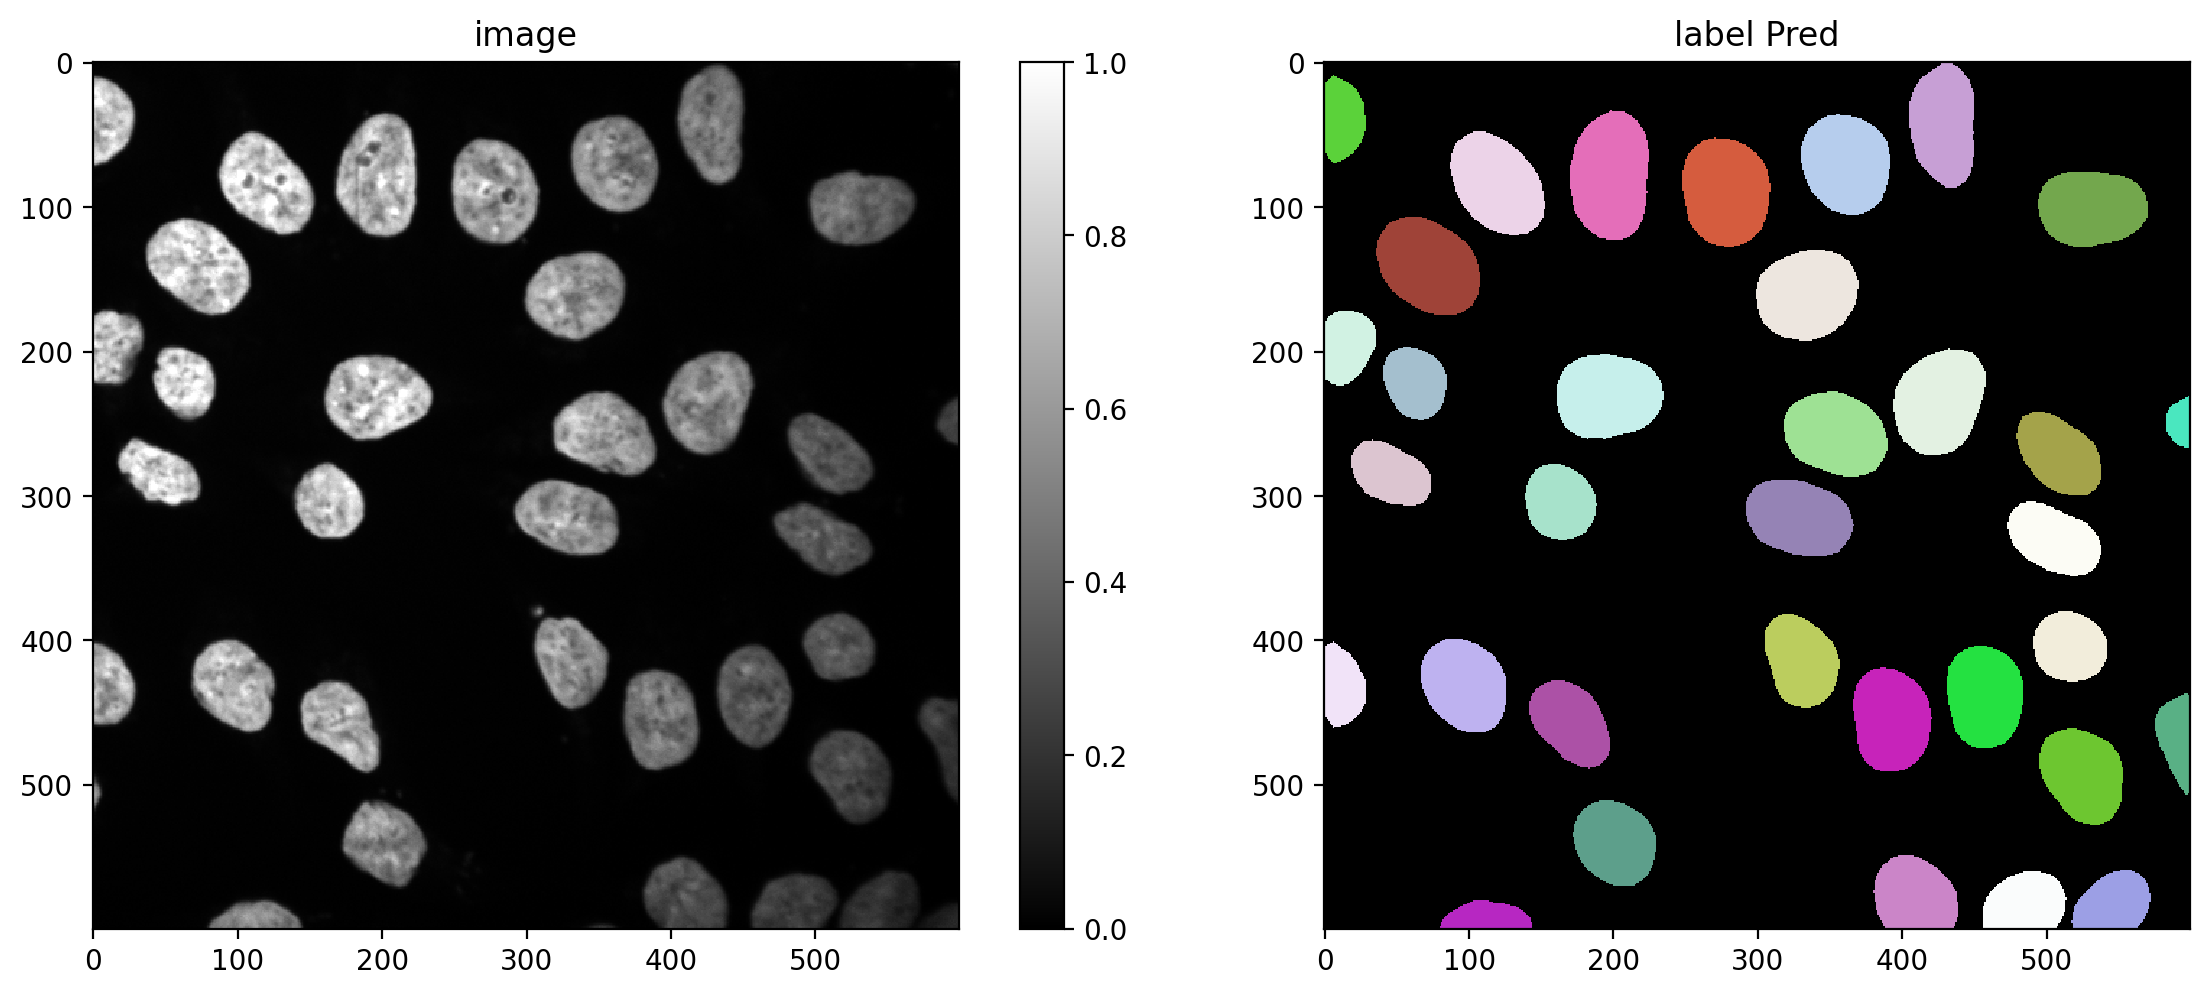

In [31]:
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")

### Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.

In [32]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 44.30it/s]


## Example: Print all available matching statistics for $\tau=0.5$

In [33]:
stats[taus.index(0.5)]

DatasetMatching(criterion='iou', thresh=0.5, fp=0, tp=34, fn=4, precision=1.0, recall=0.8947368421052632, accuracy=0.8947368421052632, f1=0.9444444444444444, n_true=38, n_pred=34, mean_true_score=0.8068961093300268, mean_matched_score=0.9018250633688534, panoptic_quality=0.8517236709594727, by_image=False)

### Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold $\tau$. 

* False positives are the number of objects that are identified that aren't there in reality.
* False negatives are the objects that are missed by the algorithm
* True positives are the ones that are correct


### As we increase tau, we tend to get many more false negatives and less true positives, as we are requiring the matches to be more and more perfect

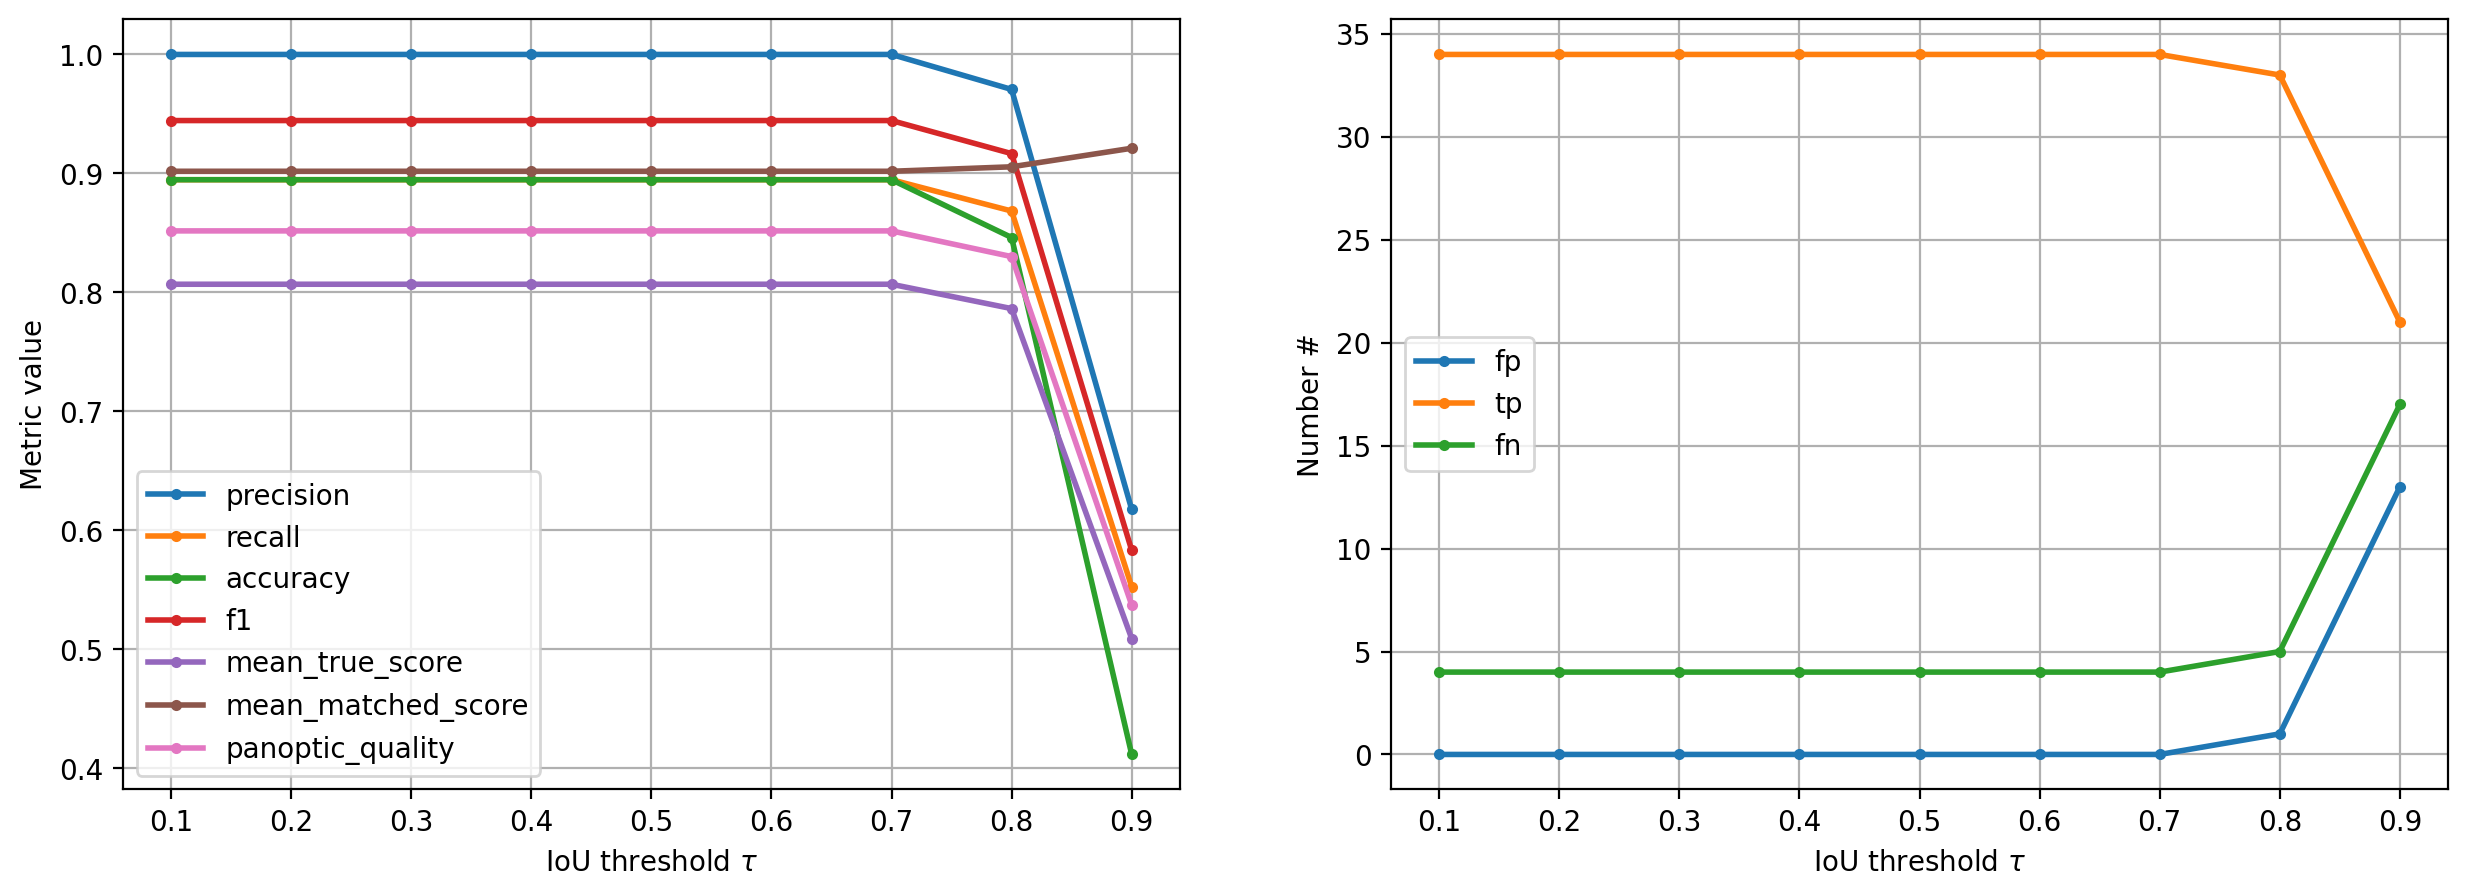

In [34]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();